In [5]:
# read all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

In [6]:
#load in the data
data = pd.read_excel('../data/oudin.xlsx', index_col='datum', parse_dates=True)

#Where are we?
# -> in Graz
lat = 47

In [7]:
M = np.pi / 180 * lat
# M is the latitude of the location in radians

# calculate the extraterrestrial radiation

# first calculate the declination of the sun
# first calculate the day of the year
doy = data.index.dayofyear

# calculate the declination of the sun

dr = 1 + 0.033 * np.cos(2 * np.pi * doy / 365)
delta = 0.409 * np.sin(2 * np.pi * doy / 365 - 1.39)

omega_s = np.arccos(-np.tan(M) * np.tan(delta))

# dr is the inverse relative distance Earth-Sun????
# delta is the declination of the sun?????
# omega_s is the sunset hour angle?????

In [8]:
Re = 24 * 60 / np.pi * 0.082 * dr * (omega_s * np.sin(M) * np.sin(delta) + np.cos(M) * np.cos(delta) * np.sin(omega_s))
# Re is the extraterrestrial radiation in MJ/m2/day

In [9]:
def ETP_oudin(Re_mm_day, Temp_avg):
    """
    This function calculates the evapotranspiration according to the Oudin method
    Parameters
    ----------
    Re_mm_day : float
        Extraterrestrial radiation in mm/day
    Temp_avg : float
        Average temperature in degrees Celsius
    Returns
    -------
    ETP : float
        Evapotranspiration in mm/day
    """

    if Re_mm_day * (Temp_avg + 5) / 100 > 0:
        ETP = Re_mm_day * (Temp_avg + 5) / 100

    else:
        ETP = 0

    return ETP

In [10]:
Re_mm_day = Re / 2.45

ETP = np.zeros(len(data))

for i in np.arange(0, len(data)):
    ETP[i] = ETP_oudin(Re_mm_day[i], data['T (°C)'].values[i])

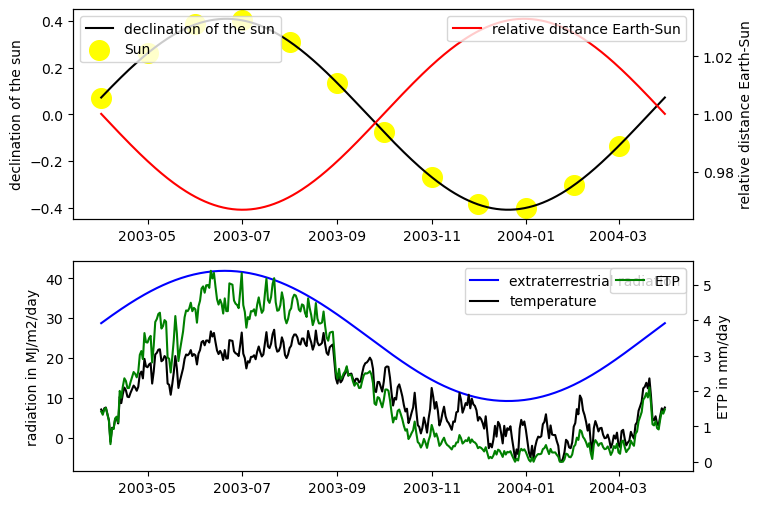

In [11]:
# create 3 subplots in one figure to show the different steps in the calculation of the ETP
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# plot the declination of the sun in an intuitive way so that students can understand what is happening
# plot sun symbols as scatter plot
ax1.plot(data.index, delta, color='black', label='declination of the sun')
# plot a yellow sun symbol for each first day of the month
ax1.scatter(data.index[data.index.day == 1], delta[data.index.day == 1], marker='o', color='yellow', label='Sun', s=200)

axtwin = ax1.twinx()
# plot relative distance Earth-Sun
axtwin.plot(data.index, dr, color='red', label='relative distance Earth-Sun')

# plot the extraterrestrial radiation
ax2.plot(data.index, Re, color='blue', label='extraterrestrial radiation')

# plot temperature
ax2.plot(data.index, data['T (°C)'], color='black', label='temperature')

ax3 = ax2.twinx()
# plot the ETP
ax3.plot(data.index, ETP, color='green', label='ETP')

# add labels and legend
ax1.set_ylabel('declination of the sun')
axtwin.set_ylabel('relative distance Earth-Sun')
ax2.set_ylabel('radiation in MJ/m2/day')
ax3.set_ylabel('ETP in mm/day')
ax1.legend(loc='upper left')
axtwin.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

In [12]:
def linear_reduction_function(volumetric_soil_moisture, wilting_point, field_capacity, fraction_of_field_capacity=0.7):
    """
    This function calculates the water stress coefficient K_s based on the volumetric soil moisture.
    Parameters
    ----------
    volumetric_soil_moisture : float
        The volumetric soil moisture in %
    wilting_point : float
        The volumetric soil moisture at the wilting point in %
    field_capacity : float
        The volumetric soil moisture at the field capacity in %
    fraction_of_field_capacity : float
        The fraction of the field capacity at which the plant starts to experience water stress
    Returns
    -------
    f_r : float
        The water stress coefficient K_s
    """ 

    # calculate the "tipping point"
    theta_0 = field_capacity * fraction_of_field_capacity 

    if volumetric_soil_moisture >= theta_0:
        f_r = 1
    
    elif volumetric_soil_moisture <= wilting_point:
        f_r = 0

    elif volumetric_soil_moisture > wilting_point and volumetric_soil_moisture < theta_0:
        f_r = (volumetric_soil_moisture - wilting_point) / (theta_0 - wilting_point)

    return f_r

def update_moisture_content(soilwater_content, PP, ETR, fc):

    # check if water holding capacity is exceeded
    if soilwater_content + PP - ETR > fc:
        updated_value = fc
        excess_water = soilwater_content + PP - ETR - fc

    else: 
        updated_value = soilwater_content + PP - ETR
        excess_water = 0

    return updated_value, excess_water

def run_simulation(fc=150, wilting_point=20, p=0.7, xrain=1):
    Re_mm_day = Re / 2.45
    Precip = data['N (mm/d)'] * xrain

    gw_flux = np.zeros(len(data))

    soil_moisture = np.zeros(len(data))
    initial_soil_moisture = fc
    soil_moisture[0] = initial_soil_moisture

    initial_fraction_of_ETP = 1
    ETR = np.zeros(len(data))

    ETP = np.zeros(len(data))
    for i in np.arange(1, len(data)):
        etp = ETP_oudin(Re_mm_day[i], data['T (°C)'].values[i])
        ETR[0] = initial_fraction_of_ETP * etp

        ETP[i] = etp

        factor = linear_reduction_function(soil_moisture[i-1], wilting_point, fc, p)
        ETR[i] = factor * ETP[i]

        soil_moisture[i], excess_water = update_moisture_content(soil_moisture[i-1], Precip[i], ETR[i], fc)

        gw_flux[i] = excess_water

    return Precip, ETP, ETR, soil_moisture, gw_flux

def plot_simulation(fc=150, wilting_point=20, p=0.7, xrain=1):
    
    Precip, ETP, ETR, soil_moisture, gw_flux = run_simulation(fc, wilting_point, p, xrain)


    fig = plt.figure(figsize=(10, 7))

    # Define the width ratio and spacing
    width_ratio = 0.3
    spacing_vertical = 0.05
    spacing_horizontal = 0.09

    # Calculate left plot width and right plot width considering the spacing
    left_plot_width = (1 - width_ratio - spacing_horizontal)
    right_plot_width = width_ratio

    # Heights and vertical positions for left plots
    height_left = (1 - 4 * spacing_vertical) / 3
    positions_left = [2/3 + spacing_vertical, 1/3 + spacing_vertical, 0 + spacing_vertical]

    # Create the existing subplots
    ax1 = fig.add_axes([0, positions_left[0], left_plot_width, height_left])
    ax2 = fig.add_axes([0, positions_left[1], left_plot_width, height_left])
    ax3 = fig.add_axes([0, positions_left[2], left_plot_width, height_left])


    # Heights and vertical positions for right plots
    height_right = (1 - 2 * spacing_vertical) / 2
    positions_right = [1/2 + spacing_vertical/2, 0 + spacing_vertical-0.05]

    # Create the new subplots on the right
    ax_right1 = fig.add_axes([1 - right_plot_width, positions_right[0], right_plot_width, height_right])
    ax_right2 = fig.add_axes([1 - right_plot_width, positions_right[1], right_plot_width, height_right])

    for ax in [ax_right1, ax_right2]:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")

    # Now plot your data as before
    ax1.bar(data.index, Precip.values, color='blue', label='precipitation', width=1)
    ax1.set_ylim(max(Precip), 0)  # This inverts the y-axis

    # plot the ETP
    ax2.plot(data.index, ETP, color='green', label='ETP')

    # plot the ETR
    ax2.plot(data.index, ETR, color='red', label='ETR')

    # plot the soil moisture storage
    ax3.plot(data.index, soil_moisture, color='blue', label='soil moisture storage')

    ax4 = ax3.twinx()
    # plot the groundwater flux
    ax4.plot(data.index, gw_flux, color='orange', label='groundwater flux')

    volumetric_soil_moisture = np.arange(0, 150, 1)
    curve = np.zeros(len(volumetric_soil_moisture))

    for value, i in zip(volumetric_soil_moisture, range(len(volumetric_soil_moisture))):
        curve[i] = linear_reduction_function(value, wilting_point, fc, p)
        
    ax_right1.plot(volumetric_soil_moisture, curve, color='blue', label='water stress coeff.')
    ax_right1.vlines(wilting_point, 0, 1, color='red',linestyle = '--',label='wilting point')
    ax_right1.vlines(fc, 0, 1, color='green',linestyle = '--',label='field capacity')
    ax_right1.set_xlabel('volumetric soil moisture')
    ax_right1.set_ylabel('Water stress coefficient K_s')
    ax_right1.set_title('Linear reduction function')

    # create bar plot for Precipitation, ETP, ETR, and gw_flux sum over whole time period
    ax_right2.bar('Precipitation', Precip.sum(), color='blue', label='precipitation', width=0.5)
    ax_right2.bar('ETP', ETP.sum(), color='green', label='ETP', width=0.5)
    ax_right2.bar('ETR', ETR.sum(), color='red', label='ETR', width=0.5)
    ax_right2.bar('gw_flux', gw_flux.sum(), color='orange', label='gw_flux', width=0.5)
    ax_right2.set_ylabel('sum over whole time period')

    ## add labels and legend
    ax1.set_ylabel('precipitation in mm/day')
    ax2.set_ylabel('ETP and ETR in mm/day')
    ax3.set_ylabel('soil moisture  in mm')
    ax4.set_ylabel('groundwater flux in mm/day')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')


In [13]:
interact(plot_simulation, 
         fc=widgets.FloatSlider(min=100, max=200, step=5, value=150),
         wilting_point=widgets.FloatSlider(min=10, max=60, step=1, value=20),
         p=widgets.FloatSlider(min=0.5, max=1.0, step=0.1, value=0.7),
         xrain=widgets.FloatSlider(min=0, max=5, step=0.5, value=1))

interactive(children=(FloatSlider(value=150.0, description='fc', max=200.0, min=100.0, step=5.0), FloatSlider(…

<function __main__.plot_simulation(fc=150, wilting_point=20, p=0.7, xrain=1)>